# Comparing the Liveability of Melbourne's Suburbs for a Migrating Individuals

## Background
When moving to a new city or shifting houses, it can be a massive decision to choose the correct locality. There are many factors which can make a neighbourhood more livable than others. It would be great if a tool existed in which a user could input the most important venues he/she prefers to live close to and in return he/she could get a comparison of suburbs which are good or bad in those metrics.

## Objective
The objective of this project is to compare the suburbs of Melbourne in terms of their livability. The algorithm is designed to take in multiple preferences in the sense of places of interest which the individual would prefer to be close to. For the example in the notebook here, the author has used his own personality and considered the following things.
- Academic (e.g. researcher, professor, PhD student) - proximity to universities, schools and colleges
- Sporty person inclined towards playing Cricket - proximity to cricket clubs and gyms
- Necessities - proximity to hospitals, groceries, supermarkets
- General categories of nearby venues e.g. restaurants, cafes, playgrounds

## Work-Flow
##### 1. Import the relevant libraries
- needless to say this is essential!

##### 2. Scrape the wikipedia page for List of Melbourne Suburbs
- using wikipedia library to scrape the suburbs list 
- clean it up (duplicates, etc.)

##### 3. Geocoding 
- use the postal_codes list from wikipedia to get cordinates from OSM geocoder
- clean it up (duplicates, etc.)

##### 4. Get Neighborhood Info
- use foursquares to get info of the surroundings
- venues such as hospitals, schools, cafes, etc. 
- user can input any params he/she wants

##### 5. Develop Proximity Score
- convert distance of nearest 5 venues in each category into a proximity score
- the nearer the venues, the higher the score

##### 6. Calculate Proximity Scores for all Suburbs
- develop algorithm to loop through all suburbs and allot proximity score

##### 7. Machine Learning Clustering
- based on the proximity of venues, suburbs are clustered using the KMeans algorithm
- 4 clusters

##### 7. Visualisation
- Geographical mapping using folium
- bar chart to compare the proximity scores of clusters
- improvised radar chart to deliver a powerful comparison between the suburbs

##### 8. Observations and Conclusions
- based on the analysis above, we chalk out various observations and conclusions
- this list is by no means exhaustive

##### 9. Supplementary
###### S1: List of Suburbs in Clusters
###### S2: Upgrades
###### - a code is developed which can be used to replace step 2 
###### - this can be used for any city/country 
###### - user inputs a location name and we use geonames API to get nearby postal codes

###### S3: Deprecated Methods
###### - original method to scrape wikipedia page (not recommended)


## 1. Import Libraries

In [1]:
#!conda install lxml 
#!conda install html5lib
!pip -q install geocoder
!pip -q install tqdm

#import wikipedia library for scraping
!pip -q install wikipedia
import wikipedia as wp

#mute a specific warning which we don't need
import warnings
warnings.filterwarnings("ignore", 'This pattern has match groups')

#map
import folium

#geocoder
import geocoder

#to handle json files
from pandas.io.json import json_normalize

import numpy as np
import pandas as pd
pd.options.display.max_rows = None

#web scraper
from bs4 import BeautifulSoup as bs
import requests

#import a timer
import tqdm 
from tqdm import tqdm_notebook 

#scaler
from sklearn.preprocessing import StandardScaler

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors

#import clustering algorithm
from sklearn.cluster import KMeans

## 2. Scrape Wikipedia Page for List of Melboure Suburbs

In [2]:
#Get the html source
wiki_page = "List of Melbourne suburbs"
html = wp.page(wiki_page).html().encode("UTF-8")
wiki_data = pd.read_html(html)[0]
#df.to_csv('suburbs.csv',header=0,index=False)
print(wiki_data.columns)
wiki_data.head(2)

Index(['Suburb', 'Postcode', 'Local government area',
       'Location[citation needed]', 'Distance[3][citation needed]',
       'Area[citation needed]', 'Population[citation needed]',
       'Population density[citation needed]',
       'Date established[citation needed]'],
      dtype='object')


,Suburb,Postcode,Local government area,Location[citation needed],Distance[3][citation needed],Area[citation needed],Population[citation needed],Population density[citation needed],Date established[citation needed]
0,Bellfield,3081,City of Banyule,NaN,NaN,0.9 km2,"1,793[4]",NaN,NaN
1,Briar Hill,3088,City of Banyule,NaN,NaN,NaN,"3,152[4]",NaN,NaN


Notes:
- We are only interested in columns: "Suburb", "Postcode", "Local government area" (optional).
- Some suburbs contain extra info in parentheses with their names e.g. "Melbourne CBD (St Kilda Road area)".
- Some suburbs share postal codes.
- Some suburbs are shared by local government areas.

Actions:
- Remove info in parentheses
- Remove all duplicate postcodes - keep first.
- Add a column for state - "VIC"
- Create an address column - "name" + "state" + "postcode" - this will be used to geocode later
- Ensure no missing values and no non-numerics in postcode

In [3]:
suburbs = wiki_data[['Suburb','Postcode','Local government area']]

# Convert everything in the df into type string
suburbs = suburbs.astype(str) 

# Remove the info in parentheses
suburbs['Suburb'] = suburbs['Suburb'].str.split("(", expand=True)[0]

# Count non-numeric postcodes
print("Non-numeric postcodes: ",suburbs[~suburbs['Postcode'].str.isnumeric()].shape[0])
suburbs = suburbs[suburbs['Postcode'].str.isnumeric()]
print("No. of Postcodes: ",suburbs.shape)

# Count duplicates and drop them
print("Duplicates: ", suburbs[suburbs.duplicated('Postcode')].shape[0])
suburbs.drop_duplicates(subset=['Postcode'], inplace = True)
print("No. of Postcodes: ",suburbs.shape)

# Add columns for state and address
suburbs['state'] = 'VIC'
suburbs['address'] = suburbs['Suburb'] + ', ' + suburbs['state'] + ', ' + suburbs['Postcode']

# Reset Indices
suburbs.reset_index(drop=True, inplace=True)
suburbs.head(2)

Non-numeric postcodes:  0
No. of Postcodes:  (549, 3)
Duplicates:  271
No. of Postcodes:  (278, 3)


,Suburb,Postcode,Local government area,state,address
0,Bellfield,3081,City of Banyule,VIC,"Bellfield, VIC, 3081"
1,Briar Hill,3088,City of Banyule,VIC,"Briar Hill, VIC, 3088"


## 3. Geocoding

In [4]:
# This code takes slightly over 2 mins

lat = []
lng = []
i=0

#get the lat and lng of the post_codes using geocoder and OSM as the provide
#NOTE: long step ~2mins - tqdm timer being used (if you are not opening in notebook, please change tqdm_notebook() to tqdm())
for i, add in tqdm_notebook(enumerate(suburbs['address']), total = len(suburbs['address'])): 
    #print(add)
    g = geocoder.osm(add)
    lat = lat + [g.latlng[0]] #list of lats
    lng = lng + [g.latlng[1]] #list of lngs

#copy the lat_lngs into the main df
suburbs[['latitude','longitude']] = pd.DataFrame(data=[lat,lng], index=['latitude','longitude']).T 

suburbs.head()

,Suburb,Postcode,Local government area,state,address,latitude,longitude
0,Bellfield,3081,City of Banyule,VIC,"Bellfield, VIC, 3081",-37.753107,145.038478
1,Briar Hill,3088,City of Banyule,VIC,"Briar Hill, VIC, 3088",-37.706370,145.121648
2,Bundoora,3083,City of Banyule; City of Darebin; City of Whit...,VIC,"Bundoora, VIC, 3083",-37.697306,145.066254
3,Eaglemont,3084,City of Banyule,VIC,"Eaglemont, VIC, 3084",-37.765144,145.063331
4,Eltham,3095,City of Banyule; Shire of Nillumbik,VIC,"Eltham, VIC, 3095",-37.713387,145.147880


#### Check for duplicates in lat-lng values

In [5]:
#Check for duplicate lat_lngs
suburbs[suburbs[['latitude','longitude']].duplicated(keep=False)]

,Suburb,Postcode,Local government area,state,address,latitude,longitude
152,Melbourne CBD,3000,City of Melbourne,VIC,"Melbourne CBD, VIC, 3000",-37.814182,144.959801
153,Melbourne CBD,3004,"City of Melbourne (east side to High Street, P...",VIC,"Melbourne CBD , VIC, 3004",-37.814182,144.959801


#### Let's remove this (hopefully) last duplicate!!

In [6]:
suburbs.drop_duplicates(subset=['latitude', 'longitude'], inplace=True)
suburbs.reset_index(inplace=True, drop=True)
suburbs = suburbs.loc[:,['Suburb', 'state','Postcode','latitude','longitude','address']]
suburbs.rename(columns = {'Suburb':'name','Postcode':'post_code'}, inplace=True)
print(suburbs.shape)
suburbs.head()

(277, 6)


,name,state,post_code,latitude,longitude,address
0,Bellfield,VIC,3081,-37.753107,145.038478,"Bellfield, VIC, 3081"
1,Briar Hill,VIC,3088,-37.706370,145.121648,"Briar Hill, VIC, 3088"
2,Bundoora,VIC,3083,-37.697306,145.066254,"Bundoora, VIC, 3083"
3,Eaglemont,VIC,3084,-37.765144,145.063331,"Eaglemont, VIC, 3084"
4,Eltham,VIC,3095,-37.713387,145.147880,"Eltham, VIC, 3095"


- OK, Looks like we are good for some FOURSQUARE ACTION!
- First, let's map out these suburbs on a map to see how they look. 


In [7]:
# Use max-min average cordinates for the center of the map
map_lat = 0.5*max(suburbs.latitude)  +  0.5*min(suburbs.latitude)  #avg lat
map_lng = 0.5*max(suburbs.longitude) +  0.5*min(suburbs.longitude) #avg lng

melb_map = folium.Map(location = [map_lat, map_lng], zoom_start = 9) 


for lat, lng, suburb in zip(suburbs['latitude'], suburbs['longitude'], suburbs['name']):
    label = f"{suburb}"
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=3,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(melb_map)  
    


melb_map

## 4. Get Neighborhood Info
Some metrics that can be used:
- Proximity to Universities.
- Proximity to Hospitals.
- Proximity to Supermarkets.
- Proximity to cricket clubs.
- Proximity to nearest train station.
- Others

NOTE: credentials have been removed.

#### Let's set Foursquare Credentials

In [47]:
# @hidden_cell

CLIENT_ID = 'INSERT FOURSQUARE ID' # your Foursquare ID
CLIENT_SECRET = 'INSERT FOURSQUARE SECRET' # your Foursquare Secret
VERSION = '20190605' # Foursquare API version

#### Testing with a single suburb - chosing index value 25 and querying for parks and playgrounds

In [23]:
s_no = 25
latitude, longitude = suburbs.loc[s_no,'latitude'], suburbs.loc[s_no,'longitude'] # 2nd suburb

query = 'playground' # Search for unis
radius = 5000 # 5km
LIMIT=100 # ambitious 

#Set up the url
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, query, radius, LIMIT)


#Let's get the results now
results = requests.get(url).json()

# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)

print(dataframe.shape)
dataframe.head()

(36, 17)


,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId
0,[],False,4f2480e9e4b0e12081c028d7,NaN,AU,NaN,Australia,NaN,2462,[Australia],"[{'label': 'display', 'lat': -37.8463144667077...",-37.846314,145.035722,NaN,NaN,Playground,v-1560102749
1,"[{'id': '4bf58dd8d48988d1e7941735', 'name': 'P...",False,4c1199596e5dc9b6c779b02d,NaN,AU,NaN,Australia,NaN,1016,[Australia],"[{'label': 'display', 'lat': -37.817318, 'lng'...",-37.817318,145.038986,NaN,NaN,Hull Street Playground,v-1560102749
2,"[{'id': '4bf58dd8d48988d1e7941735', 'name': 'P...",False,4e90e90c550342b5a46dc53c,NaN,AU,NaN,Australia,NaN,989,[Australia],"[{'label': 'display', 'lat': -37.8312407239625...",-37.831241,145.024495,NaN,NaN,Kevin Bartlett Reserve Playground,v-1560102749
3,"[{'id': '4bf58dd8d48988d1e7941735', 'name': 'P...",False,4c957f00034137047cad7cef,NaN,AU,NaN,Australia,NaN,1524,[Australia],"[{'label': 'display', 'lat': -37.8254151115657...",-37.825415,145.014426,NaN,NaN,Burnley Park Playground,v-1560102749
4,"[{'id': '4bf58dd8d48988d1e7941735', 'name': 'P...",False,4b21d98df964a520f64124e3,37 Aughtie Dr,AU,Albert Park,Australia,NaN,6346,"[37 Aughtie Dr, Albert Park VIC 3206, Australia]","[{'label': 'display', 'lat': -37.8484123577023...",-37.848412,144.966235,3206,VIC,Middle Park Community Playground,v-1560102749


#### Let's understand the categories column a bit

In [24]:
# how the categories column looks
dataframe.loc[1,'categories']

[{'id': '4bf58dd8d48988d1e7941735',
  'name': 'Playground',
  'pluralName': 'Playgrounds',
  'shortName': 'Playground',
  'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/parks_outdoors/playground_',
   'suffix': '.png'},
  'primary': True}]

#### We need the 'name' (of category) field only! Let's use the get_category_type() func to fetch the 'name' of category

In [25]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe['categories'] = dataframe.apply(get_category_type, axis=1)


dataframe['categories'].value_counts()

Playground         28
Park                2
Office              2
History Museum      1
Conference Room     1
Bar                 1
Name: categories, dtype: int64

#### There are lots of unnecessary categories

In [26]:
dataframe[['categories','name','location.distance']].head(10)

,categories,name,location.distance
0,None,Playground,2462
1,Playground,Hull Street Playground,1016
2,Playground,Kevin Bartlett Reserve Playground,989
3,Playground,Burnley Park Playground,1524
4,Playground,Middle Park Community Playground,6346
5,Playground,Prahran Market Playground,4242
6,Bar,Playground,5753
7,Playground,Playground Gold St,4833
8,Office,Playground Finder HQ,5066
9,Playground,Frog Hollow Playground,3932


#### Also, there are some venues not in the designated radius. We will perform a number of filtering and clean up steps:
1. Filter only venues which contain the query word in the sec_filter field i.e. 'categories' or 'name'.
2. Remove those venues further than the radius.
3. Remove venues without the category info.

In [27]:
dataframe['categories'].fillna(value=pd.np.nan, inplace=True) #make None categories NaN
sec_filter = 'categories' #used to filter second time

# Create a new df
df = dataframe.copy(deep=True) 
df.sort_values(by='location.distance', inplace=True) # sort by distance
df = df[df['location.distance']<radius] # filter out results > 5km (radius)
print('After removing those too far: ', df.shape)

df.fillna(value=np.nan, inplace=True) #make None sec_filter items NaN
print('After making empty fields Nan: ', df.shape)

df[sec_filter] = df.loc[:,sec_filter].astype(str) #make them string
print('After making sec_filter field a string: ', df.shape)

df.dropna(subset=[sec_filter], inplace=True) #drop if NaN
print('After dropping Nan: ', df.shape)

df = df[df[sec_filter].str.lower().str.contains(query)] # select only categories containing 'query' e.g. university
print('After dropping non-matching results: ', df.shape)

df.reset_index(inplace=True,drop=True)
print("Rows left: ",df.shape[0])
df[['name','categories']]

After removing those too far:  (22, 17)
After making empty fields Nan:  (22, 17)
After making sec_filter field a string:  (22, 17)
After dropping Nan:  (22, 17)
After dropping non-matching results:  (19, 17)
Rows left:  19


,name,categories
0,Kevin Bartlett Reserve Playground,Playground
1,Hull Street Playground,Playground
2,Burnley Park Playground,Playground
3,Osama Playground,Playground
4,Frog Hollow Playground,Playground
5,Chaucer Crescent Playground,Playground
6,Lumley Children's Playground,Playground
7,Prahean Market Playground,Playground
8,Prahran Market Playground,Playground
9,Powlett Street Reserve Playground,Playground


##### Sometimes, there are still some duplicates which aren't caught easily. E.g. in university search, multiple colleges of the same university come up many times. The following lines of code can deal with that. However, this will later be only used as an optional step, that the user needs to activate by passing a pseudos_opt = 'remove' command. The reason is that some queries might give venues with very generic names e.g. club or mosque. In that case this code will wipe out even the proper nouns!

In [30]:
# This code will clear pseudo duplicates. It will loop through original dataframe['name'] column and if the name matches any of the new df['name'], it will mark them as True in the ['dupl'] column.
# Then it will replace the True value with a counting number according to their proximity, 1 being closest. Those cells not matching will still contain value False (which is equal to 0)
# Then we will keep only those rows where value <= 1
for i, name in enumerate(df['name']):
    name = name.lower()
    df['dupl'] = df['name'].str.lower().str.contains(name)
    x = 1
    for i, value in enumerate(df['dupl']):
        if value:
            df.loc[i,'dupl'] = x
            x = x + 1
    df = df[df['dupl']<2]
    df.reset_index(inplace=True, drop=True)
print("Rows left:",df.shape[0])
df[['name','categories','location.distance']]

Rows left: 19


,name,categories,location.distance
0,Kevin Bartlett Reserve Playground,Playground,989
1,Hull Street Playground,Playground,1016
2,Burnley Park Playground,Playground,1524
3,Osama Playground,Playground,2849
4,Frog Hollow Playground,Playground,3932
5,Chaucer Crescent Playground,Playground,4033
6,Lumley Children's Playground,Playground,4179
7,Prahean Market Playground,Playground,4241
8,Prahran Market Playground,Playground,4242
9,Powlett Street Reserve Playground,Playground,4244


CAUTION: Pseudo filter must be used with caution esp if we expect some search results to be very generic. Unless really necessary, AVOID!

In [31]:
dataframe['categories'].fillna(value=pd.np.nan, inplace=True) #make None categories NaN
sec_filter = 'categories' #used to filter second time
df = dataframe.copy(deep=True) 
df.sort_values(by='location.distance', inplace=True) # sort by distance
df = df[df['location.distance']<radius] # filter out results > 5km (radius)
df.fillna(value=np.nan, inplace=True) #make None sec_filter items NaN
df[sec_filter] = df.loc[:,sec_filter].astype(str) #make them string
df.dropna(subset=[sec_filter], inplace=True) #drop if NaN
df = df[df[sec_filter].str.lower().str.contains(query)] # select only categories containing 'query' e.g. university
df.reset_index(inplace=True,drop=True)
df[['name','categories']]

,name,categories
0,Kevin Bartlett Reserve Playground,Playground
1,Hull Street Playground,Playground
2,Burnley Park Playground,Playground
3,Osama Playground,Playground
4,Frog Hollow Playground,Playground
5,Chaucer Crescent Playground,Playground
6,Lumley Children's Playground,Playground
7,Prahean Market Playground,Playground
8,Prahran Market Playground,Playground
9,Powlett Street Reserve Playground,Playground


## 5. Develop Proximity Score
##### This looks clean and neat! NOTE: We will see if we should be stricter with the allowed distance later.

#### Now we will create a new metric which will be a measure of how good this location is w.r.t. closeness to universities. We will only choose the top 5 results. How the metric works is that:
- Each suburb starts with a score of radius x max which for universities is 5000m x 5unis = 25000.
- For every location in the top5, we will calculate its relative closeness e.g. Victoria University is 2022 m away, that means it's "2978m" closer than the radius of 5000m we set.
- Then we subtract out 2978m (relative closeness) from the initial score of 25000m. During the ML part, these scores must be normalized.
- A perfect location would have very low final score while the worst location will have 25000m.

The formula would look like:


<img src="labs/DP0701EN/Uni_Score.png" alt="Drawing" style="width: 500px;"/>


In [32]:
df = df.loc[:,['name','categories','location.distance']]
df['rel_close'] = radius - df['location.distance']
df

,name,categories,location.distance,rel_close
0,Kevin Bartlett Reserve Playground,Playground,989,4011
1,Hull Street Playground,Playground,1016,3984
2,Burnley Park Playground,Playground,1524,3476
3,Osama Playground,Playground,2849,2151
4,Frog Hollow Playground,Playground,3932,1068
5,Chaucer Crescent Playground,Playground,4033,967
6,Lumley Children's Playground,Playground,4179,821
7,Prahean Market Playground,Playground,4241,759
8,Prahran Market Playground,Playground,4242,758
9,Powlett Street Reserve Playground,Playground,4244,756


In [33]:
uni_score = df['rel_close'].head().sum()
uni_score

14690

#### This score will be one of the features for the suburbs called <query_name>_score e.g. university_score!!

## 6. Get Proximity Scores for all Suburbs
- Let's create functions which we can use for looping this workflow for all the suburbs!

#### A. Funciton which cleans up the category column of the foursquare venue info

In [34]:
#Get the categories from the dict
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#### B. Develop function to calculate the score given venue info

In [35]:
def calc_score(dataframe,query, pseudos, sec_filter,radius):
    # Create a new df
    df = dataframe.copy(deep=True) 
    df.sort_values(by='location.distance', inplace=True) # sort by distance
    df = df[df['location.distance']<radius] # filter out results > 5km (radius)
    df.fillna(value=np.nan, inplace=True) #remove rows which have no sec_filter
    df[sec_filter] = df.loc[:,sec_filter].astype(str) #convert all to string
    df.dropna(subset=[sec_filter], inplace=True)
    df = df[df[sec_filter].str.lower().str.contains(query)] # select only categories containing 'query' e.g. university
    df.reset_index(inplace=True,drop=True)
        
    if pseudos == 'remove':

        for i, name in enumerate(dataframe['name']):
            try:
                df['dupl'] = df['name'].str.lower().str.contains(name.lower(), regex=False) #if pseudo duplicate, mark as True
                x = 1
                for i, value in enumerate(df['dupl']): #for all true, give a number 1,2,3...
                    if value == True:
                        df.loc[i,'dupl'] = x
                        x = x + 1
                df = df[df['dupl']<2] #only keep counter number 1 (so we get rid of duplicates)
                df.reset_index(inplace=True, drop=True)
            except:
                pass
        #print("Rows left:",df.shape[0])

    df = df[['name','categories','location.distance']]
    df['rel_close'] = radius - df['location.distance']
    score = df['rel_close'].head().sum()
    
    return df, score

#### C. Develop a function to get venue information from foursquare and then invoke calc_score() func

In [36]:
def get_scores(suburbs, query, radius, sec, pseudos_opt, LIMIT):
    score_list = []
    for lat, lng, name in tqdm_notebook(zip(suburbs['latitude'], suburbs['longitude'],
                                            suburbs['name']), total = len(suburbs)):
        #Set up the url
        url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, lat, lng, VERSION, query, radius, LIMIT)

        results = requests.get(url).json() #Get the results 
        venues = results['response']['venues'] # Assign relevant part of JSON to venues
        dataframe = json_normalize(venues) # tranform venues into a dataframe

        if dataframe.empty: #cater for no results
            score = 0 #give max penalty
        else:
            dataframe['categories'] = dataframe.apply(get_category_type, axis=1) #update the categories 

            df_clean, score = calc_score(dataframe,query, pseudos = pseudos_opt, sec_filter=sec,radius=radius) #get scores

        score_list = score_list + [score]
    
    score_label = query + "_score"
    score_label = score_label.replace(" ", "_")
    score_list = pd.DataFrame(data=score_list, columns = [score_label])
    
    return score_list

#### D. Master Function - Loops through set of queries parameters.
- Takes in query parameters
- Calls function 3 to get venue info
- Then calls function 2 to calculate proximity scores
- Creates df with the proximity scores of each suburb for each query 
- Concats the scores df to the suburb df to return a master df

##### OPTIONAL: For getting scores of a single query

Double-click __here__ for getting scores of a single query (OPTIONAL).

<!-- 
# "Convert this cell into a code cell to run code for single query set"
query, radius, sec, pseudos_opt, LIMIT = ['playground', 2000, 'categories','',100]

score_list_temp = get_scores(suburbs=suburbs3,query=query,radius=radius,
                                 sec=sec,pseudos_opt ='pseudos_opt', LIMIT=LIMIT)
#concat the scores for all queries
score_list = pd.concat([score_list,score_list_temp],axis=1,sort=False)

#concat the scores to the suburbs df    
suburbs3=pd.concat([suburbs3, score_list], axis=1, sort=False)
suburbs3 = suburbs3.loc[:,~suburbs3.columns.duplicated()]
print(suburbs3.head(2))
suburbs3.mean()                               

-->

##### Following code fetches proximity scores for the entire list of suburbs

In [38]:
'''
define search queries/parameters in order:[query,radius,sec_filter,pseudo_opt,LIMIT]
query: [string] search key words - may use multiple synonyms with | splitter e.g. school|college
radius: [int,float] distance from suburb in meters
sec_filter: ['names' or 'categories'] attribute used to ensure relevancy of search results
pseudo_opt: ['remove' or ''] option to remove pseudo duplicates e.g. University of Melbourne AND Office of Admissions University of Melbourne
    use with caution as it can remove all search results if one of the result is a generic one e.g. 'university'
LIMIT: [int] limit for number of search results from each query search
'''

params_list = [['university|school|college', 2000, 'categories', 'remove', 100],
            ['hospital|clinic', 2000, 'categories', '', 100],
            ['cricket club', 2000, 'name', '', 100],
            ['train station', 2000, 'categories', '', 100],
            ['supermarket|grocery', 2000, 'categories', '', 100],
            ['cafe|restaurant', 2000, 'categories', '', 100],
            ['shopping mall', 2000, 'categories', '', 100],
            ['playground', 2000, 'categories', '', 100],
            ['gym', 2000, 'categories', '', 100]
           ]

#transpose params_list to make it iterable
params = list(map(list, zip(*params_list)))

suburbs3 = suburbs.copy(deep=True)  #select df to be processed
score_list =pd.DataFrame() #create empty dataframe to be filled with scores

for query, radius, sec, pseudos_opt, LIMIT in zip(*params): #send all the params with the df
    #create temp df of that query's scores -> call get_scores()
    print(query)
    score_list_temp = get_scores(suburbs=suburbs3,query=query,radius=radius,
                                 sec=sec,pseudos_opt ='pseudos_opt', LIMIT=LIMIT)
    #concat the scores for all queries
    score_list = pd.concat([score_list,score_list_temp],axis=1,sort=False)

#concat the scores to the suburbs df    
suburbs3=pd.concat([suburbs3, score_list], axis=1, sort=False)
suburbs3.head()                               

university|school|college


hospital|clinic


cricket club


train station


supermarket|grocery


cafe|restaurant


shopping mall


playground


gym


,name,state,post_code,latitude,longitude,address,university|school|college_score,hospital|clinic_score,cricket_club_score,train_station_score,supermarket|grocery_score,cafe|restaurant_score,shopping_mall_score,playground_score,gym_score
0,Bellfield,VIC,3081,-37.753107,145.038478,"Bellfield, VIC, 3081",0,1776,296,1606,241,2510,1743,0,1908
1,Briar Hill,VIC,3088,-37.706370,145.121648,"Briar Hill, VIC, 3088",0,0,1059,1757,732,3181,0,753,633
2,Bundoora,VIC,3083,-37.697306,145.066254,"Bundoora, VIC, 3083",0,3088,1551,0,1285,5064,1312,916,1298
3,Eaglemont,VIC,3084,-37.765144,145.063331,"Eaglemont, VIC, 3084",0,5070,0,2605,2088,4964,869,0,118
4,Eltham,VIC,3095,-37.713387,145.147880,"Eltham, VIC, 3095",0,0,0,1987,0,5389,1789,0,2032


## 7. Machine Learning - Clustering.
- First, we split the data in suburb_names (labels) and suburb_scores (features).
- Then, we will normalize the feature values (don't think it would make much difference for clustering)
- Then we do KMeans clustering 
- Finally, we map out the clusters!

In [39]:
#split up the labels and features
if 'cluster labels' in suburbs3.columns:
    suburbs.drop(labels = ['Cluster labels'], axis=1, inplace=True)
suburb_names = np.asarray(suburbs3['name'])
suburb_scores = np.asarray(suburbs3[[col for col in suburbs3.columns if col.endswith('score')]])

#scale the features (not necessary for clustering)
suburb_scores_scaled = StandardScaler().fit(suburb_scores).transform(suburb_scores)

# set number of clusters
kclusters = 4

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(suburb_scores_scaled)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/jupyterlab/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([2, 3, 3, 2, 2, 2, 0, 3, 3, 3], dtype=int32)

## 8. Visualisation 
- Let's map out to geographically visualize the clusters

In [40]:
# add clustering labels
#suburbs.insert(0, 'Cluster Labels', kmeans.labels_)
suburbs3['Cluster labels'] = kmeans.labels_

# Use Melbourne's latlng for the center of the map
melb = geocoder.osm('Melbourne')
map_lat = melb.latlng[0]
map_lng = melb.latlng[1]

map_clusters = folium.Map(location = [map_lat, map_lng], zoom_start = 10) 

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]


# add markers to the map
#markers_colors = []
for lat, lon, poi, cluster in zip(suburbs3['latitude'],suburbs3['longitude'], suburbs3['name'], suburbs3['Cluster labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=3,
        popup=label,
        color=rainbow[cluster],
        fill=True,
        fill_color=rainbow[cluster],
        fill_opacity=0.7).add_to(map_clusters)

    
folium.TileLayer('cartodbpositron').add_to(map_clusters)
       
map_clusters

- Let's create a colored table to show the cluster labels and their respective colors

In [41]:
# function returns color for cluster number
def _color_coding(val):
    if val> len(rainbow)-1:
        color = None
    else:
        color = rainbow[val]
    return 'color: %s' % color

cluster_counts = suburbs3['Cluster labels'].value_counts(sort=False) 
cluster_counts = cluster_counts.to_frame()
cluster_counts['Cluster'] = cluster_counts.index
cluster_counts[['Cluster','Cluster labels']].style.applymap(_color_coding)

,Cluster,Cluster labels
0,0,152
1,1,18
2,2,68
3,3,39


- Create some visuals to compare the attributes of the clusters

In [42]:
imp = ['name', 'Cluster labels']+ [col for col in suburbs3.columns if col.endswith('score')] # list of imp columns
imp_wo_name = ['Cluster labels']+ [col for col in suburbs3.columns if col.endswith('score')] # list of imp columns except name 
x=suburbs3[imp].groupby('Cluster labels').mean()/suburbs3[imp_wo_name].groupby('Cluster labels').max() # normalized mean scores for clusters
x #n normalized scores

,university|school|college_score,hospital|clinic_score,cricket_club_score,train_station_score,supermarket|grocery_score,cafe|restaurant_score,shopping_mall_score,playground_score,gym_score
Cluster labels,,,,,,,,,
0,0.006579,0.027208,0.045499,0.079053,0.048552,0.143200,0.080360,0.088658,0.063845
1,0.329349,0.490716,0.184575,0.461871,0.651603,0.781073,0.276908,0.577765,0.654528
2,0.031548,0.181907,0.133236,0.394355,0.214516,0.602739,0.290266,0.330865,0.306928
3,0.025641,0.139142,0.571222,0.236429,0.146567,0.456205,0.262177,0.247816,0.246450


- Create a bar chart to show the scores for the suburbs

(0, 1)

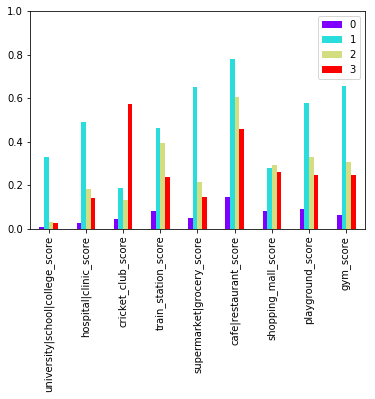

In [43]:
x.T.plot(kind='bar',figsize=(6,4), color = rainbow)
plt.legend(x.index, loc = 'upper right')
plt.xticks(rotation='vertical')
plt.ylim(0,1)

- Clearly, the blue cluster is the best overall. If you see the map, they are also the most centrally located in and around CBD which makes sense. 
- The above graphic is very cluttered. 
- Let's get a better visual using an improvised radar chart!

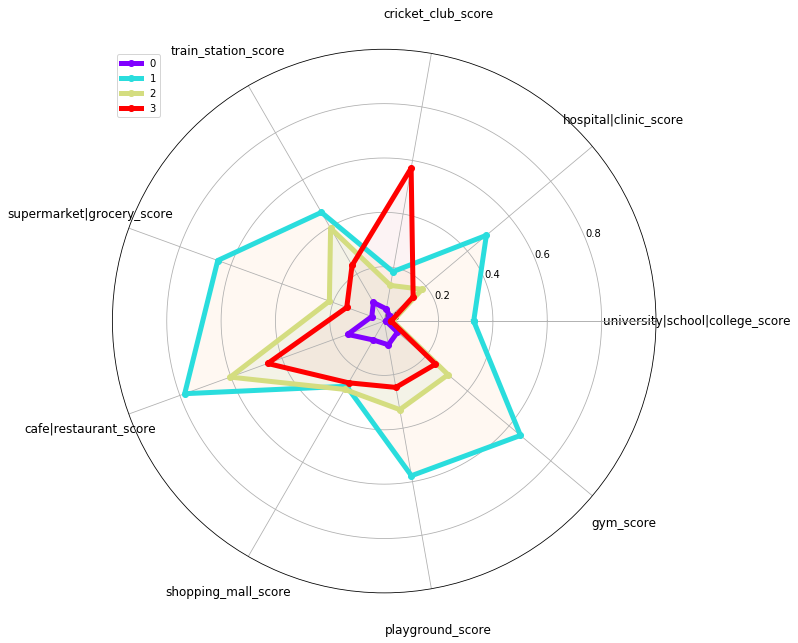

In [44]:
labels_radar = [str(col) for col in suburbs3.columns if col.endswith('score')]

stats=x.loc[:,[col for col in suburbs3.columns if col.endswith('score')]].values
angles=np.linspace(0, 2*np.pi, len([col for col in suburbs3.columns if col.endswith('score')]), endpoint=False)
# close the plot
stats=np.insert(stats, stats.shape[1], stats[:,0], axis=1)
angles=np.concatenate((angles,[angles[0]]))
fig=plt.figure(figsize=(12,10))
ax = fig.add_subplot(111, polar=True)
for k,i in enumerate(stats):
    ax.plot(angles, i, 'o-', linewidth=5, color = rainbow[k])
    ax.fill(angles, i, alpha=0.05)
ax.set_thetagrids(angles * 180/np.pi, labels_radar, fontsize=12, position=(0.0,-0.1))
ax.legend(x.index, loc='upper left')
ax.set_ylim(0,1)
ax.set_yticks([0,0.2,0.4,0.6,0.8],minor=False)
ax.grid(True)

- This graphic is much more powerful as a storytelling tool.
- The various vertices show the score of the clusters in each category. 
- The bigger the area the better the cluster overall. 
- Again, the blue cluster emerges as the clear winner followed by red and golden while purple is the worse suburbs as per the metrics of comparison!

In [45]:
map_clusters

## 9. Observations and Conclusions
Now the above map makes much more sense. Let's list down some observations:
- The blue suburbs are prime locations. Red and golden are mediocre. Purple are low value.
- Most prime locations are expectedly in and around the CBD
- Most low value suburbs are further away from central Melbourne
- Clayton is an anomaly. It is far from the CBD and still orange which means it's the best!
- Lots of mid-value suburbs are present in the southern parts of Melbourne along the coast even though they are very far from the CBD.
- The above is especially true for cluster 3 (red), which according to the radar chart is the best cluster for cricket_club proximity - so it might suit some!
- There are also a few low value suburbs in close proximity to the CBD area e.g. Port Melbourne and West Melbourne
- Except for the purple group, all suburbs have shopping malls at similar distances away.

## 10. Supplementary Information

### S1: List of suburbs in all the clusters! (Optional)

##### Cluster 1

In [ ]:
suburbs3.loc[suburbs3['Cluster labels'] == 0, suburbs3.columns[[1] + list(range(5, suburbs3.shape[1]))]]

##### Cluster 2

In [ ]:
suburbs3.loc[suburbs3['Cluster Labels'] == 1, suburbs3.columns[[1] + list(range(5, suburbs3.shape[1]))]]

##### Cluster 3

In [ ]:
suburbs3.loc[suburbs3['Cluster Labels'] == 2, suburbs3.columns[[1] + list(range(5, suburbs3.shape[1]))]]

##### Cluster 4

In [ ]:
suburbs3.loc[suburbs3['Cluster Labels'] == 3, suburbs3.columns[[1] + list(range(5, suburbs3.shape[1]))]]

##### Cluster 5 (NOTE: Won't work if only 4 clusters)

In [ ]:
suburbs3.loc[suburbs3['Cluster Labels'] == 4, suburbs3.columns[[1] + list(range(5, suburbs3.shape[1]))]]

### S2: Update

##### In order to make this code universal, i.e. not specific to Melbourne, I have developed the following code which gets a location input from the user and then generates postal codes in that region!

- Set up credentials for the geonames API
- NOTE: credentials have been removed

In [48]:
# @hidden_cell
user_id = 'INSERT GEONAMES ID'

- Prompt user to for city and country name

In [ ]:
place_name = input("Name of place (e.g. city, state, country): ")
url = f'http://api.geonames.org/findNearbyPostalCodesJSON?placename={place_name}&maxRows=500&country=AU&radius=30&username={user_id}'

#### Use city and country name to get postal codes of neighbourhood 

get_postal_codes = requests.get(url).json()

suburbs = json_normalize(get_postal_codes['postalCodes'])
print("Shape of dataframe: ", suburbs.shape)
suburbs.head(5)

- It is obvious that there are lots of repeats!! Let's first tidy up the column names and create an address attribute which we will use for geocoding.

In [ ]:
suburbs.rename(columns = {'adminCode1': 'state_code',
                          'adminName1': 'state',
                          'countryCode': 'country_code',
                          'placeName': 'name',
                          'postalCode': 'post_code',
                          #'lat': 'latitude',
                          #'lng': 'longitude'},
                         },
               inplace=True)
suburbs['address'] = suburbs['name'] + ', ' + suburbs['state_code'] + ', ' + suburbs['post_code']
suburbs = suburbs.loc[:,['name','state','state_code','country_code','post_code','address']]
suburbs.head(2)

### Now let's do some clean up:
- Reorder everything on postal codes for ease
- Remove duplicates based on suburb name and postal code
- Reset indices

In [ ]:
print(suburbs.shape)
suburbs.sort_values(by=['post_code'], inplace=True) #sort by suburb post_code
print(suburbs.shape)
suburbs.drop_duplicates(subset=['name'], inplace=True) #drop duplicate suburb names
print(suburbs.shape)
suburbs.drop_duplicates(subset=['post_code'], inplace=True) #drop duplicate suburb post_codes
print(suburbs.shape)
suburbs.reset_index(drop=True, inplace=True)
print("Final number of post-codes: ",suburbs.shape[0])
suburbs.head(2)

- Let's see if some unwanted results have sneaked in. 

In [ ]:
suburbs['state'].value_counts()

##### Indeed, some have! Unfortunately, to create a one-for-all solution to get rid of these won't be easy. So we will let this be. It might go away after geocoding. If not, it should not impact clustering that much (hopefully)!

- Now let's geocode using the OpenStreetMaps API

In [ ]:
# This code takes slightly over 2 mins

lat = []
lng = []
i=0

#get the lat and lng of the post_codes using geocoder and OSM as the provide
#NOTE: long step ~2mins - tqdm timer being used (if you are not opening in notebook, please change tqdm_notebook() to tqdm())
for i, add in tqdm_notebook(enumerate(suburbs['address']), total = len(suburbs['address'])): 
    #print(add)
    g = geocoder.osm(add)
    if len(g) == 0: # append np.nan for addresses which don't give cordinates - drop later
        lat = lat + [np.nan] 
        lng = lng + [np.nan]
    else:
        lat = lat + [g.latlng[0]] #list of lats
        lng = lng + [g.latlng[1]] #list of lngs

#copy the lat_lngs into the main df
suburbs[['latitude','longitude']] = pd.DataFrame(data=[lat,lng], index=['latitude','longitude']).T 

suburbs.head()

- The geocoding function appends NaN values if geocoding fails. So we need to remove those rows with NaN values for cordinates

In [ ]:
suburbs = suburbs[~suburbs['latitude'].isnull()]
suburbs.reset_index(drop=True, inplace=True)
suburbs = suburbs[~suburbs.duplicated(subset=['latitude','longitude'])]
suburbs.reset_index(drop=True, inplace=True)
print("Postcodes remaining: suburbs.shape[0])

- This is the final number of post_codes remaining. Our dataframe of suburbs looks ready for further assessment!

### S3: Deprecated Methods

### Method 1

##### This method had to be deprecated because during the development of this notebook, the wikipedia page changed from list-style to table-style. So all that effort wasted!

#### Let's fetch the wikipedia page which contains the list of Melbourne's suburbs.

The url used is: https://en.wikipedia.org/wiki/List_of_Melbourne_suburbs

#Get the html source code for the wikipedia page
source = requests.get('https://en.wikipedia.org/wiki/List_of_Melbourne_suburbs').text

soup = bs(source, 'lxml') #decode
#print(soup.prettify()) #display
#NOTE: soup.get_text() will get all the text on that page. Through some trial and error, I could isolate text indices 7274 till 29752 which were for the suburbs
#The above is a weak method because any update in the wiki page will break it down. I should ideally be fetching the suburbs in a smarter manner through tags - will improve on this

#### If you want to have a look run the print code in the previous cell. All that we need is in the <li tag

sub_list = [] #create an empty list
x=0 #create counter
for text in soup.find_all('li', class_ = None): #loop through all the <li tags without any class - these are where the suburbs are
    #print(x)
    #x +=1
    sub_list=sub_list+[text] #add suburbs to list

suburbs1 = pd.DataFrame(sub_list, columns=['name']) #convert list to df
suburbs1.head()

#### Data clean up time!

#suburbs1.shape

suburbs1['name'] = suburbs1['name'].astype(str) #change dtype to string

suburbs1[['1','2']] = suburbs1["name"].str.split("<a href=", n = 1, expand = True) #split through <a href= delimiter - link after this

suburbs1[['3','4']] = suburbs1['2'].str.split("title=", n = 1, expand = True) #split across title= after which suburb name is 

suburbs1[['5','6']] = suburbs1['4'].str.split("</a> ", n = 1, expand = True) #split across <a/a tag - after which postal code is

suburbs1['post_code'] = suburbs1['6'].str[:4] #crop out first four characs of postal code

suburbs1.drop(['name','2','4','6'], axis=1) #drop the unnecessary coloums

print(suburbs1.shape)
suburbs1.head()

#### Removing those rows which aren't holding post_codes as they aren't rows containing suburb info

suburbs1['post_code']

print("Originally", suburbs1.shape)

suburbs1 = suburbs1.dropna(subset=['post_code'])
suburbs1.drop_duplicates(inplace=True, subset=['post_code']) #drop duplicate postal codes
print("After dropping duplicates", suburbs1.shape)

suburbs1 = suburbs1[~suburbs1['post_code'].str.contains("[a-zA-Z]").fillna(False)] #removing postal codes = None
print("After dropping Nones", suburbs1.shape)

non_num_index = suburbs1.index[~suburbs1['post_code'].str.isnumeric()] #check for any non-numeric cell
print("Check non-numeric values: ", non_num_index)

suburbs1.drop(index=non_num_index, inplace=True) #remove non-numeric postal code
print("After dropping non-numeric", suburbs1.shape)
suburbs1.sort_values(by=['post_code'], inplace=True)
suburbs1.head(2)

#### Postal codes all cleaned up. Total of 271 unique postal codes. Next step is to clean up the other columns.
#### We will limit our columns to 3: "name", "post_code", "links"

#Create link - we stitch the "https://..." to the link in column['3']
suburbs1['links'] = str("https://en.wikipedia.org") + suburbs1['3'].str.split("\"",expand=True)[1]

#Splice out the suburb name from column['5'] - needs three splits based on ',' | '>' | '('
suburbs1['name'] = suburbs1['5'].str.split(",", expand= True)[0].str.replace("\"","")
suburbs1['name'] = suburbs1['name'].str.split(">", expand= True)[0]
suburbs1['name'] = suburbs1['name'].str.split("(", expand=True)[0]

#select the meaningful columns Suburb, post_code and links | Rename to suburbs
suburbs = suburbs1[['name','post_code','links']]
suburbs.reset_index(drop=True,inplace=True)
print(suburbs1.shape)
suburbs.head()

#### Now let's add "state" column with value "VIC" for Victoria and create an "address" column stitching together the name, state and post_code

suburbs['state'] = 'VIC'
suburbs['address'] = suburbs['name']+', '+suburbs['state']+', '+suburbs['post_code']
suburbs = suburbs[['name', 'state','post_code','links', 'address']]
suburbs.head()

#### I have a bad feeling about this Melbourne City Centre possible duplicate. We will evaluate this after the geocoding. If it's a different lat_lng then, we will treat it differently. For now let's use OPEN STREET MAPS (OSM) with the geocoder library to fetch the latitudes and longitudes

#### Head's up, this step takes slightly over 2 mins

lat = []
lng = []
i=0

#get the lat and lng of the post_codes using geocoder and OSM as the provide
#NOTE: long step ~2mins - tqdm timer being used (if you are not opening in notebook, please change tqdm_notebook() to tqdm())
for i, add in tqdm_notebook(enumerate(suburbs['address']), total = len(suburbs['address'])): 
    g = geocoder.osm(add)
    lat = lat + [g.latlng[0]] #list of lats
    lng = lng + [g.latlng[1]] #list of lngs

#copy the lat_lngs into the main df
suburbs[['latitude','longitude']] = pd.DataFrame(data=[lat,lng], index=['latitude','longitude']).T 

suburbs.head()

#### Of course Melbourne City Center is a duplicate - just how data works! 
#### And an interesting one this - different post_code but same name and geocoding. Let's check if there are more!

#Check for duplicate lat_lngs
suburbs[suburbs['latitude'].duplicated(keep=False)]

#### Let's remove this (hopefully) last duplicate!!

suburbs.drop_duplicates(subset=['latitude'], inplace=True)
suburbs.reset_index(inplace=True, drop=True)
suburbs = suburbs[['name', 'state','post_code','latitude','longitude','links','address']]
print(suburbs.shape)
suburbs.head()

#One last check for any nonesense
suburbs1 = suburbs.dropna()

suburbs1.shape

### Method 2

This method was unsuitable as it assumes the wikipedia page will never change

#Two things being done in the next line of code
#1. Get the text -> place in df using new rows for different lines
#2. Place a '|' wherever there is a bracket so that we can use it as a delimiter without removing the bracket
wiki_text = pd.DataFrame(soup.get_text()[7274:29752].replace('(', '|(').split('\n'), columns=['Suburbs']) 


#wiki_text['Suburbs'] = wiki_text['Suburbs'].astype('str') #convert to string <- not working
wiki_text.head()
wiki_text.tail()
wiki_text.dtypes

suburbs = wiki_text["Suburbs"].str.split("|", n = 1, expand = True) #split the cells using the | we placed so that Suburbs column only has suburb name
suburbs.columns = ['Suburb', 'Info'] #name the columns

suburbs['Suburb'] = suburbs['Suburb'].str.replace('[^a-zA-Z0-9]', ' ') #replace any non alpha numeric character by a space (to remove any strange characters)

suburbs.dtypes
suburbs.shape
suburbs.head(100)

#If you see above, the Suburb columns have some values without a postal code. Actually these are just names are areas within the parent suburbs which is the value before it
#We need to remove those rows. We can therefore try to remove any rows where the suburb cells have no numbers i.e. no postal code.

suburbs['characs'] =suburbs.Suburb.str.replace('[^a-zA-Z0-9]','') # create a new column with just the letters and numbers in the Suburbs columns
suburbs['characs'] = suburbs['characs'].str.isalpha() #convert the column to true if it has no numbers
suburbs = suburbs[suburbs['characs']== False].drop('characs', axis = 1) #drop any rows where the characs is False i.e. it has only letters 
suburbs.head()

#suburbs.describe() 
#It was seen that some Suburbs are being duplicated!! Turns out that these suburbs are shared between multiple cities. So we must remove them!
suburbs.drop_duplicates(subset='Suburb',inplace=True)
suburbs.shape

#In order to ensure that the suburb column only had suburbs I decided to see the len of characters in it
suburbs['len'] = list(map(lambda x: len(x), suburbs['Suburb']))
suburbs.describe()

All the quartiles are within a tight region, but somehow the max is almost 6 times bigger than the mean! I guess there are some sentences which have survived. Let's see what they are!

suburbs[suburbs['len']>25].sort_values('len',ascending=False)

Indeed, it is a sentence probably a caption to an image! This again reinstates the need to fetch data in a smarter way than just indexing the entire text of a html page! Sigh
Now, for those 44 and above, we can just remove.
For Diggers Rest, it seems like it is still a suburb but it has a string at the end. We will deal with it also.

suburbs[suburbs['Suburb'].str.contains('3427')]

Well, turns out Diggers Rest is a duplicate as well!! We can just drop it as well. So keep only those rows which have character len less than 29

suburbs = suburbs[suburbs['len']<29]
suburbs.shape